In [1]:
from fastai2.basics import *
from fastai2.vision.all import *

import kornia
from mish_cuda import MishCuda

from tqdm.notebook import tqdm

import astropy.io.ascii
from astropy.coordinates import SkyCoord, matching
import astropy.units as u

PATH = Path('../..').resolve()

%matplotlib inline

seed = 12345

In [2]:
from PIL import Image
import skimage
import sklearn, skimage.measure
from sklearn import linear_model
import sklearn.decomposition
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import sklearn.ensemble
import sklearn_pandas

# general hyperparms
validation_pct = 0.2
seed = 12345

# RF
num_trees = 100

# pca
n_components = 16
batch_size = 200

In [3]:
torch.cuda.set_device('cuda:0')

# reproducability flags
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

item_tfms = []
batch_tfms = aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.)+[Normalize.from_stats(*image_stats)]

def root_mean_squared_error(preds, targs):  return torch.sqrt(F.mse_loss(preds.reshape(-1, 1), targs.reshape(-1, 1)))
def slope(p, y): return ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

In [5]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv')
y = df.logfgas.to_numpy()

In [6]:
X = np.load(f'{PATH}/data/raveled_a40A_images.npy')

# Linear model

## Train

In [7]:
X = X.reshape((len(X), 224, 224, 3))

In [8]:
X_mini = skimage.measure.block_reduce(X, (1, 7, 7, 1), np.mean)

In [9]:
X_mini = X_mini.reshape(len(y), -1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_mini, y, test_size=0.2, random_state=seed)

In [11]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

p_lin = reg.predict(X_test)

## Test on NIBLES

In [12]:
nib = pd.read_csv(f'{PATH}/results/nibles/nibles_clean_results.csv')
X_NIBLES = np.array([np.array(Image.open(f'{PATH}/images-nibles_cleaned/{o}.jpg')) for o in nib.nibles_id])



In [13]:
X_NIBLES = skimage.measure.block_reduce(
    X_NIBLES, 
    (1, 7, 7, 1), 
    np.mean
)

y_NIBLES = nib.fgas_true

In [14]:
p_lin_NIBLES = reg.predict(X_NIBLES.reshape(len(X_NIBLES), -1))

# PCA + RF

## PCA decompose

In [15]:
X = np.load(f'{PATH}/data/raveled_a40A_images.npy')
X_NIBLES = np.array([np.array(Image.open(f'{PATH}/images-nibles_cleaned/{o}.jpg')) for o in nib.nibles_id])

y = df.logfgas.to_numpy()

In [16]:
pca = sklearn.decomposition.IncrementalPCA(n_components=n_components, batch_size=batch_size)

In [17]:
pca.fit(X)
X_pca = pca.transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=validation_pct, random_state=seed)

## Random forest

In [19]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=num_trees, random_state=seed)

In [20]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=12345, verbose=0, warm_start=False)

In [21]:
p_PCA_RF = rf.predict(X_test)

## Test with NIBLES

In [22]:
X_NIBLES_pca = pca.transform(X_NIBLES.reshape((len(X_NIBLES), -1)))


In [23]:
p_NIBLES_PCA_RF = rf.predict(X_NIBLES_pca)


# PCA + polynomial

In [24]:
poly = PolynomialFeatures(degree=1)

X_poly = poly.fit_transform(X_pca)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=seed)

In [26]:
polyreg = linear_model.LinearRegression()

polyreg.fit(X_train, y_train)

p_PCA_poly = polyreg.predict(X_test)

In [27]:
X_NIBLES_pca_poly = poly.transform(X_NIBLES_pca)
p_NIBLES_PCA_poly = polyreg.predict(X_NIBLES_pca_poly)

# Plotty

## Get CNN preds

In [28]:
a40A_results = pd.read_csv(f'{PATH}/results/final/a40A_predictions.csv', usecols=(1,2))
_, p_a40A, _, y_a40A = train_test_split(a40A_results.fgas_pred, a40A_results.fgas_true, test_size=0.2, random_state=seed)

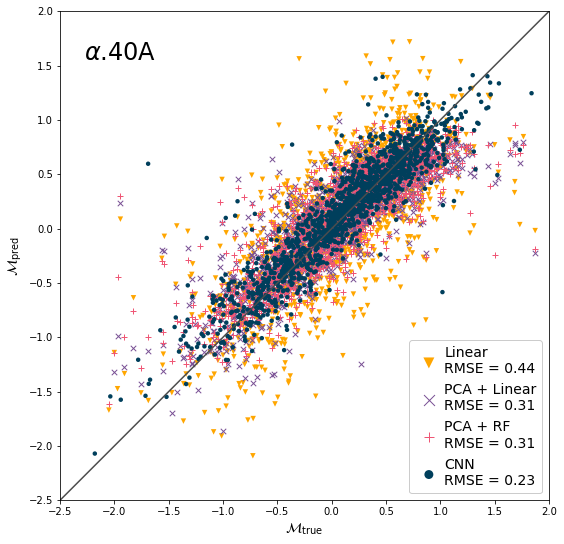

In [29]:
fig, ax = plt.subplots(1,1, figsize=(9, 9))

# get stats
rmse_linear = ((p_lin - y_test)**2).mean()**0.5
rmse_PCA_RF = ((p_PCA_RF - y_test)**2).mean()**0.5
rmse_PCA_poly = ((p_PCA_poly - y_test)**2).mean()**0.5
rmse_CNN = ((p_a40A - y_a40A)**2).mean()**0.5


ax.scatter(y_test, p_lin, edgecolors='none', c='#ffa600', s=30, marker='v', label='Linear\n' f'RMSE = {rmse_linear:.2f}')
ax.scatter(y_test, p_PCA_poly, edgecolors='none', c='#7a5195', s=30, marker='x', lw=1, label=f'PCA + Linear\n' f'RMSE = {rmse_PCA_poly:.2f}')
ax.scatter(y_test, p_PCA_RF, edgecolors='none', c='#ef5675', s=30, marker='+', lw=1, label=f'PCA + RF\n' f'RMSE = {rmse_PCA_RF:.2f}')
ax.scatter(y_a40A, p_a40A, edgecolors='none', c='#003f5c', s=20, marker='o', lw=1, label=f'CNN\n' f'RMSE = {rmse_CNN:.2f}')


ax.plot([-3, 2], [-3, 2], c='0.3')
ax.set_aspect('equal')
ax.set_xlim(-2.5, 2)
ax.set_ylim(-2.5, 2)

ax.text(0.05, 0.9, r'$\alpha$.40A', fontsize=24, transform=ax.transAxes)

ax.legend(loc='lower right', fontsize=14, framealpha=1, markerscale=2, handletextpad=0.1)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.savefig(f'{PATH}/results/final/simple-model-combined-comparison_a40A.pdf')

In [58]:
NIBLES_results = pd.read_csv(f'{PATH}/results/final/nibles_predictions.csv', usecols=(1,2))
p_CNN_NIBLES, y_CNN_NIBLES = NIBLES_results.fgas_pred, NIBLES_results.fgas_true

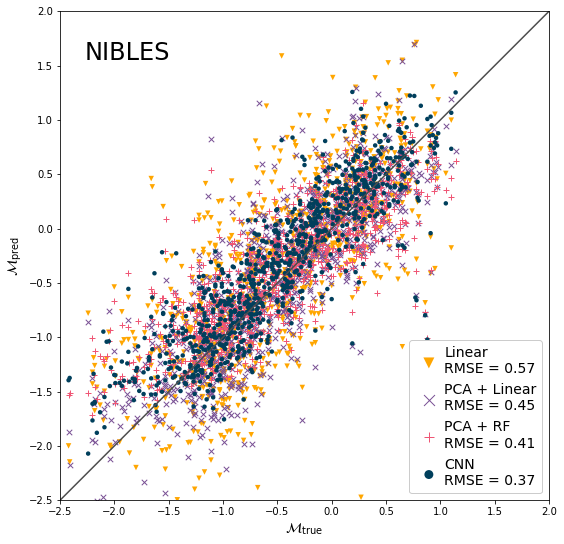

In [59]:
fig, ax = plt.subplots(1,1, figsize=(9, 9))

# get stats
rmse_linear = ((p_lin_NIBLES - (y_NIBLES))**2).mean()**0.5
rmse_PCA_poly = ((p_NIBLES_PCA_poly - (y_NIBLES))**2).mean()**0.5
rmse_PCA_RF = ((p_NIBLES_PCA_RF - (y_NIBLES))**2).mean()**0.5
rmse_CNN = ((p_CNN_NIBLES - (y_CNN_NIBLES))**2).mean()**0.5

ax.scatter((y_NIBLES), p_lin_NIBLES, edgecolors='none', c='#ffa600', s=30, marker='v', label='Linear\n' f'RMSE = {rmse_linear:.2f}')
ax.scatter((y_NIBLES), p_NIBLES_PCA_poly, edgecolors='none', c='#7a5195', s=30, marker='x', lw=1, label=f'PCA + Linear\n' f'RMSE = {rmse_PCA_poly:.2f}')
ax.scatter((y_NIBLES), p_NIBLES_PCA_RF, edgecolors='none', c='#ef5675', s=30, marker='+', lw=1, label=f'PCA + RF\n' f'RMSE = {rmse_PCA_RF:.2f}')
ax.scatter((y_CNN_NIBLES), p_CNN_NIBLES, edgecolors='none', c='#003f5c', s=20, marker='o', lw=1, label=f'CNN\n' f'RMSE = {rmse_CNN:.2f}')

ax.plot([-3, 2], [-3, 2], c='0.3')
ax.set_aspect('equal')
ax.set_xlim(-2.5, 2)
ax.set_ylim(-2.5, 2)

ax.text(0.05, 0.9, 'NIBLES', fontsize=24, transform=ax.transAxes)
ax.legend(loc='lower right', fontsize=14, framealpha=1, markerscale=2, handletextpad=0.1)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.savefig(f'{PATH}/results/final/simple-model-combined-comparison_NIBLES.pdf')

## Subplots

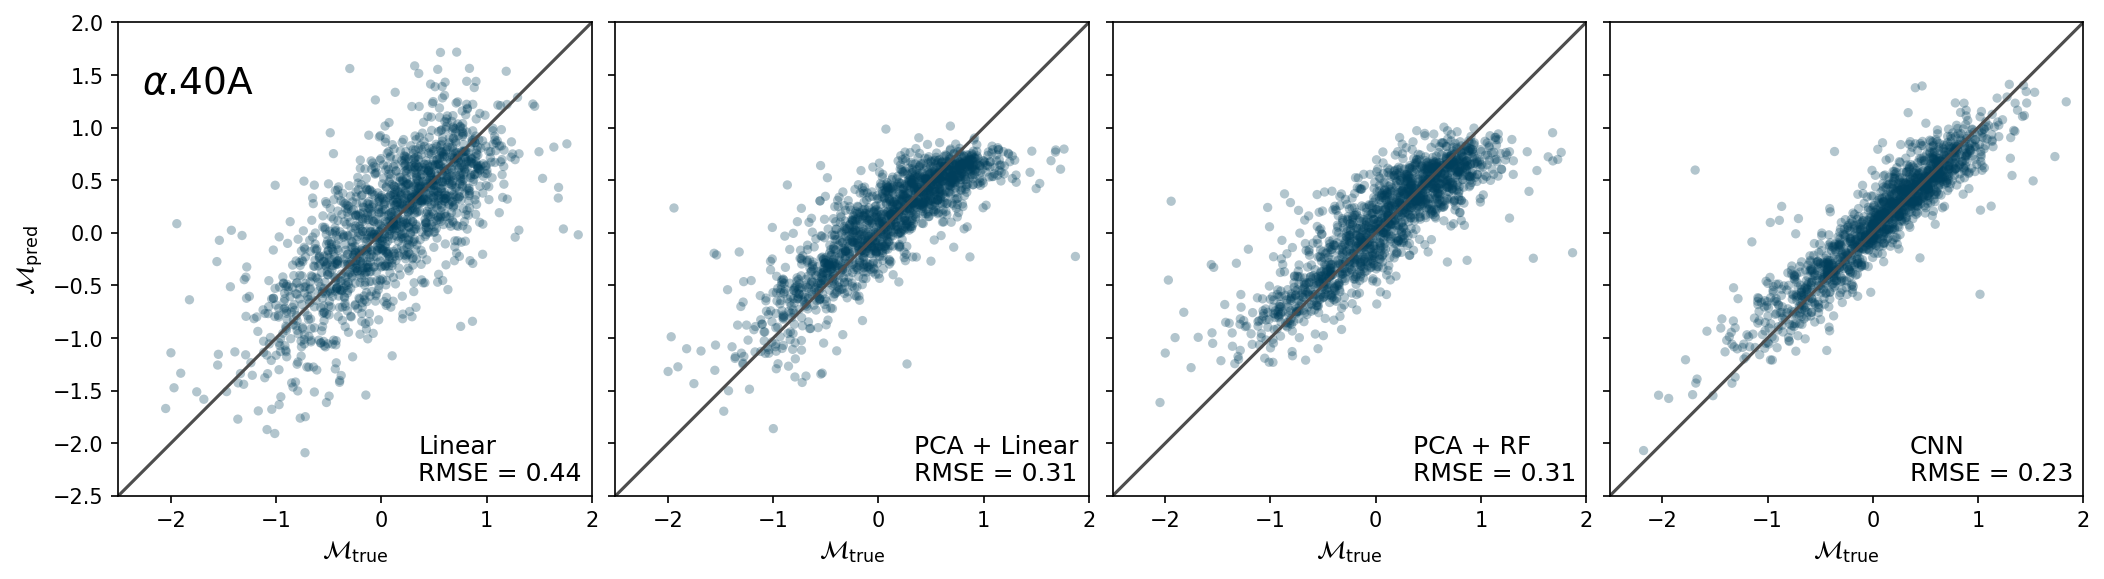

In [57]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharey=True,  dpi=150, subplot_kw={'aspect':'equal'})

ax0, ax1, ax2, ax3 = axes.flat

# get stats
rmse_linear = ((p_lin - y_test)**2).mean()**0.5
rmse_PCA_RF = ((p_PCA_RF - y_test)**2).mean()**0.5
rmse_PCA_poly = ((p_PCA_poly - y_test)**2).mean()**0.5
rmse_CNN = ((p_a40A - y_a40A)**2).mean()**0.5


ax0.scatter(y_test, p_lin, edgecolors='none', c='#003f5c', s=20, marker='o', alpha=0.3, label='Linear\n' f'RMSE = {rmse_linear:.2f}')
ax1.scatter(y_test, p_PCA_poly, edgecolors='none', c='#003f5c', s=20, marker='o', alpha=0.3,  label=f'PCA + Linear\n' f'RMSE = {rmse_PCA_poly:.2f}')
ax2.scatter(y_test, p_PCA_RF, edgecolors='none', c='#003f5c', s=20, marker='o', alpha=0.3, label=f'PCA + RF\n' f'RMSE = {rmse_PCA_RF:.2f}')
ax3.scatter(y_a40A, p_a40A, edgecolors='none', c='#003f5c', s=20, marker='o', alpha=0.3, label=f'CNN\n' f'RMSE = {rmse_CNN:.2f}')

for ax in axes.flat:
    ax.plot([-3, 2], [-3, 2], c='0.3')
    ax.set_aspect('equal')
    ax.set_xlim(-2.5, 2)
    ax.set_ylim(-2.5, 2)
    ax.set_xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
    ax.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=0, borderaxespad=0)

axes[0].text(0.05, 0.85, r'$\alpha$.40A', fontsize=18, transform=axes[0].transAxes)
axes[0].set_ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

fig.tight_layout()
fig.subplots_adjust(wspace=0.05)

plt.savefig(f'{PATH}/results/final/simple-model-comparison_a40A.pdf')

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharey=True,  dpi=150, subplot_kw={'aspect':'equal'})

ax0, ax1, ax2, ax3 = axes.flat

rmse_linear = ((p_lin_NIBLES - (y_NIBLES))**2).mean()**0.5
rmse_PCA_poly = ((p_NIBLES_PCA_poly - (y_NIBLES))**2).mean()**0.5
rmse_PCA_RF = ((p_NIBLES_PCA_RF - (y_NIBLES))**2).mean()**0.5
rmse_CNN = ((p_CNN_NIBLES - (y_CNN_NIBLES))**2).mean()**0.5

ax0.scatter(y_NIBLES, p_lin_NIBLES, edgecolors='none', c='#003f5c', s=20, marker='o', alpha=0.3, label='Linear\n' f'RMSE = {rmse_linear:.2f}')
ax1.scatter(y_NIBLES, p_NIBLES_PCA_poly, edgecolors='none', c='#003f5c', s=20, marker='o', alpha=0.3,  label=f'PCA + Linear\n' f'RMSE = {rmse_PCA_poly:.2f}')
ax2.scatter(y_NIBLES, p_NIBLES_PCA_RF, edgecolors='none', c='#003f5c', s=20, marker='o', alpha=0.3, label=f'PCA + RF\n' f'RMSE = {rmse_PCA_RF:.2f}')
ax3.scatter(y_CNN_NIBLES, p_CNN_NIBLES, edgecolors='none', c='#003f5c', s=20, marker='o', alpha=0.3, label=f'CNN\n' f'RMSE = {rmse_CNN:.2f}')

for ax in axes.flat:
    ax.plot([-3, 2], [-3, 2], c='0.3')
    ax.set_aspect('equal')
    ax.set_xlim(-2.5, 2)
    ax.set_ylim(-2.5, 2)
    ax.set_xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
    ax.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=0, borderaxespad=0)

axes[0].text(0.05, 0.85, r'NIBLES', fontsize=18, transform=axes[0].transAxes)
axes[0].set_ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

fig.tight_layout()
fig.subplots_adjust(wspace=0.05)

plt.savefig(f'{PATH}/results/final/simple-model-comparison_NIBLES.pdf')